In [18]:
import os
import numpy as np
import IPython
import copy
from shutil import copyfile

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

import sys
sys.dont_write_bytecode=True

PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

from influence.inceptionModel import BinaryInceptionModel
from influence.logisticRegressionWithLBFGS import LogisticRegressionWithLBFGS
from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
import influence.experiments
from influence.dataset import DataSet
# from influence.dataset_poisoning import iterative_attack, select_examples_to_attack, get_projection_to_box_around_orig_point, generate_inception_features
from influence.iter_attack import iterative_attack, select_examples_to_attack, get_projection_to_box_around_orig_point, generate_inception_features
from influence.Progress import *

from load_animals import *

from skimage import io

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
img_side = 299
num_channels = 3
 
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]

weight_decay = 0.001

num_classes = 3
max_lbfgs_iter = 1000

# num_train_ex = 1800
# num_test_ex = 600
# batch_size = 100

# dataset_name = 'dogfish_%s_%s' % (num_train_ex, num_test_ex)
# # data_sets = load_animals(
# #     num_train_ex_per_class=num_train_ex_per_class, 
# #     num_test_ex_per_class=num_test_ex_per_class,
# #     classes=['dog', 'fish'])
# # data_sets = load_dogfish_with_orig_and_koda()
# # X, Y = load_koda()
# # print(X.shape, Y.shape)
# data_sets = new_load_dogfish_with_koda(num_train_ex, num_test_ex)

num_train_ex_per_class = 500
num_test_ex_per_class = 50
batch_size = 50

dataset_name = 'multiclass_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
# extract_and_rename_animals()
data_sets = load_animals(
    num_train_ex_per_class=num_train_ex_per_class, 
    num_test_ex_per_class=num_test_ex_per_class,
#     classes=['Eagle', 'Komodo_Dragon', 'Snail', 'Ox', 'Mushroom'])
    classes=['Eagle', 'Snail', 'Mushroom'])

# dataset_name = 'dogfish_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
# # extract_and_rename_animals()
# data_sets = load_animals(
#     num_train_ex_per_class=num_train_ex_per_class, 
#     num_test_ex_per_class=num_test_ex_per_class,
# #     classes=['Eagle', 'Komodo_Dragon', 'Snail', 'Ox', 'Mushroom'])
#     classes=['dog', 'fish'])


np.random.seed()

full_graph = tf.Graph()
top_graph = tf.Graph()

def render_img(img):
    img_copy = np.copy(img)
    img_copy /= 2
    img_copy += 0.5
    io.imshow(img_copy)

Loading animals from disk...
../data/dataset_Eagle-Snail-Mushroom_train-500_test-50.npz


In [20]:
print('*** Full:')
with full_graph.as_default():
    full_model_name = '%s_inception_wd-%s' % (dataset_name, weight_decay)
    full_model = BinaryInceptionModel(
        img_side=img_side,
        num_channels=num_channels,
        weight_decay=weight_decay,
        num_classes=num_classes, 
        batch_size=batch_size,
        data_sets=data_sets,
        initial_learning_rate=initial_learning_rate,
        keep_probs=keep_probs,
        decay_epochs=decay_epochs,
        mini_batch=True,
        train_dir='output',
        log_dir='log',
        model_name=full_model_name)
    
    for data_set, label in [
        (data_sets.train, 'train'),
        (data_sets.test, 'test')]:

        inception_features_path = 'output/%s_inception_features_new_%s.npz' % (dataset_name, label)
        if not os.path.exists(inception_features_path):

            print('Inception features do not exist. Generating %s...' % label)
            data_set.reset_batch()
            
            num_examples = data_set.num_examples
#             assert num_examples % batch_size == 0

            inception_features_val = generate_inception_features(
                full_model, 
                data_set.x, 
                data_set.labels, 
                batch_size=batch_size)
            
            np.savez(
                inception_features_path, 
                inception_features_val=inception_features_val,
                labels=data_set.labels)
            
train_f = np.load('output/%s_inception_features_new_train.npz' % dataset_name)
inception_X_train = DataSet(train_f['inception_features_val'], train_f['labels'])
test_f = np.load('output/%s_inception_features_new_test.npz' % dataset_name)
inception_X_test = DataSet(test_f['inception_features_val'], test_f['labels'])

validation = None

inception_data_sets = base.Datasets(train=inception_X_train, validation=validation, test=inception_X_test)

print('*** Top:')
with top_graph.as_default():
    top_model_name = '%s_inception_onlytop_wd-%s' % (dataset_name, weight_decay)
    input_dim = 2048
    if num_classes == 2:
        LogReg = BinaryLogisticRegressionWithLBFGS
    else:
        LogReg = LogisticRegressionWithLBFGS
    top_model = LogReg(
        input_dim=input_dim,
        weight_decay=weight_decay,
        max_lbfgs_iter=max_lbfgs_iter,
        num_classes=num_classes, 
        batch_size=batch_size,
        data_sets=inception_data_sets,
        initial_learning_rate=initial_learning_rate,
        keep_probs=keep_probs,
        decay_epochs=decay_epochs,
        mini_batch=False,
        train_dir='output',
        log_dir='log',
        model_name=top_model_name)
    weights = top_model.retrain_and_get_weights(inception_X_train.x, inception_X_train.labels)
    orig_weight_path = 'output/inception_weights_%s.npy' % top_model_name
    np.save(orig_weight_path, weights)
    
with full_graph.as_default():
    full_model.load_weights_from_disk(orig_weight_path, do_save=False, do_check=True)

### Create poisoned dataset
print('Creating poisoned dataset...')

step_size = 0.02
print('step_size is', step_size)

num_train = len(data_sets.train.labels)
num_test = len(data_sets.test.labels)
max_num_to_poison = 10

### Try attacking each test example individually

# orig_X_train = np.copy(data_sets.train.x)
# orig_Y_train = np.copy(data_sets.train.labels)

test_indices_to_attack = [15]


for test_idx in test_indices_to_attack:

    print('****** Attacking test_idx %s ******' % test_idx)
    test_description = test_idx

    # If this has already been successfully attacked, skip
    filenames = [filename for filename in os.listdir('./output') if (
        (('%s_attack_testidx-%s_trainidx-' % (full_model.model_name, test_description)) in filename) and        
        (filename.endswith('stepsize-%s_proj_final.npz' % step_size)))]
        # and (('stepsize-%s_proj_final.npz' % step_size) in filename))] # Check all step sizes        
    if len(filenames) > 0:
        print('test_idx %s has already been successfully attacked. Skipping...')
        continue
        
    # Use top model to quickly generate inverse HVP
#     dup_incep = DataSet(np.copy(inception_X_test.x), np.copy(inception_X_test.labels))
#     dup_incep.labels[test_idx] = 0

    with top_graph.as_default():
        get_hvp(
            top_model,
            inception_X_test, inception_X_train,
            test_description=test_description,
            test_idx = [test_idx],
            force_refresh=True)
    copyfile(
        'output/%s-test-%s.npz' % (top_model_name, test_description),
        'output/%s-test-%s.npz' % (full_model_name, test_description))
        
    # Use full model to select indices to poison
    with full_graph.as_default():
        grad_influence_wrt_input_val_subset = get_grad_of_influence_wrt_input(full_model, 
                                                    [test_idx], data_sets.test, 
                                                    np.arange(num_train), data_sets.train, 
                                                    test_description,
                                                    force_refresh=False)
        # save into file for caching 
        print("finished calculating grad_wrt_input_val")
        pred_diff = np.sum(np.abs(grad_influence_wrt_input_val_subset), axis = 1)
        all_indices_to_poison = np.argsort(pred_diff)[-1:-max_num_to_poison-1:-1]
#     all_indices_to_poison =  [1141,1454,1447,158,306,1484,1589,1354,721,1295]
    print("-----------------------")
    print("-----------------------")
    print("all_indices_to_poison: ", all_indices_to_poison)
    # for 15: 999,  172, 1302,  492, 1446,  164,  153, 1186,   47,  575

    for num_to_poison in [0.1]:
        # If we're just attacking one training example, try attacking the first one and also the second one separately
        if num_to_poison == 0.1:
#             indices_to_poison = all_indices_to_poison[0:1]
            indices_to_poison = all_indices_to_poison[0:1]
            print('indices_to_poison', indices_to_poison)
        elif num_to_poison == 1.2:
            indices_to_poison = all_indices_to_poison[1:2]
        else:
            indices_to_poison = all_indices_to_poison[:num_to_poison]
        
        orig_X_train_subset = np.copy(data_sets.train.x[indices_to_poison, :])
        orig_X_train_inception_features_subset = np.copy(inception_X_train.x[indices_to_poison, :])

        project_fn = get_projection_to_box_around_orig_point(orig_X_train_subset, box_radius_in_pixels=0.5)

        attack_success_incep, attack_success_image = iterative_attack(top_model, full_model, top_graph, full_graph, project_fn, 
                                          [test_idx], 
                                          test_description, 
                                          data_sets.train, data_sets.test, dataset_name,
                                          indices_to_poison=indices_to_poison,
                                          num_iter=100,
                                          step_size=step_size,
                                          save_iter=100,
                                          early_stop=0.5,
#                                           target_labels=[0]
                                            )
        new_incep_feat = np.copy(inception_X_train.x[indices_to_poison, :])
        with full_graph.as_default():
            data_sets.train.x[indices_to_poison, :] = orig_X_train_subset
            full_model.load_weights_from_disk(orig_weight_path, do_save=False, do_check=False)
        with top_graph.as_default():
            inception_X_train.x[indices_to_poison, :] = orig_X_train_inception_features_subset
            top_model.retrain_and_get_weights(inception_X_train.x, inception_X_train.labels)

#         if attack_success:
#             break

*** Full:
self.logits Tensor("Shape:0", shape=(2,), dtype=int32)


[genericNeuralNet.py:194 -   get_vec_to_list_fn() ] Total number of parameters: 6144


wrong_labels_bool Tensor("Shape_2:0", shape=(2,), dtype=int32)
logits Tensor("Shape_3:0", shape=(2,), dtype=int32)
inception_features:  Tensor("flatten/Reshape:0", shape=(?, ?), dtype=float32)
x_poison_features:  Tensor("Gather:0", shape=(1, ?), dtype=float32)
t_target_features:  Tensor("Gather_1:0", shape=(1, ?), dtype=float32)
Lp:  Tensor("Square:0", shape=(), dtype=float32)
LP_gradient Tensor("strided_slice_1:0", shape=(268203,), dtype=float32)
*** Top:
self.logits Tensor("Shape:0", shape=(2,), dtype=int32)


[genericNeuralNet.py:194 -   get_vec_to_list_fn() ] Total number of parameters: 6144


wrong_labels_bool Tensor("Shape_2:0", shape=(2,), dtype=int32)
logits Tensor("Shape_3:0", shape=(2,), dtype=int32)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0023825786
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.00059130485
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.006721925
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   1.0
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 2.5170758e-07
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 1.8927616


LBFGS training took [38] iter.
After training with LBFGS: 


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: [0.00238258]
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.0005913]
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00672192]
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   [1.]
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 2.4505522e-07
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 1.8927616


Creating poisoned dataset...
('step_size is', 0.02)
****** Attacking test_idx 15 ******
Total number of parameters: 6144
Optimization terminated successfully.
         Current function value: -0.000340
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 10
         Hessian evaluations: 26
Inverse HVP took 0.586875915527 sec
Loaded inverse HVP from output/multiclass_500_50_inception_wd-0.001-test-15.npz
Inverse HVP took 0.000508069992065 sec
Entering the for loop
finished calculating grad_wrt_input_val


[iter_attack.py:122 -     iterative_attack() ] Test idx: [15], Indices to poison: [355], train label: [0.], test label: 0.0


-----------------------
-----------------------
('all_indices_to_poison: ', array([ 355,   77,  419, 1049,  469,   64,   98, 1446,  461,  364]))
('indices_to_poison', array([355]))



[iter_attack.py:135 -     iterative_attack() ] Initial Test pred (full): [[9.9989915e-01 3.1207892e-05 6.9640831e-05]]
[iter_attack.py:138 -     iterative_attack() ] Initial Test pred (top): [[9.9989915e-01 3.1207892e-05 6.9640831e-05]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 0


Total number of parameters: 6144


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 0 perturbation shape: (1, 268203), perturbation: [[-4.36063565e-05 -9.18216756e-07  1.26366012e-05 ... -1.85357676e-05
  -1.10969286e-05  9.15239434e-06]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 0.004840562120079994, mean: -7.993999117549278e-08, min: -0.005008206702768803


Optimization terminated successfully.
         Current function value: -0.000340
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 10
         Hessian evaluations: 26
Inverse HVP took 0.52842092514 sec
Loaded inverse HVP from output/multiclass_500_50_inception_wd-0.001-test-15.npz
Inverse HVP took 0.000507116317749 sec
Entering the for loop
[[-4.36063565e-05 -9.18216756e-07  1.26366012e-05 ... -1.85357676e-05
  -1.10969286e-05  9.15239434e-06]]
1 1


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0024013151
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.00061718706
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.0067341686
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   1.0
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0011122443
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 1.888983


Shape (1, 2048)
Using normal model
LBFGS training took [31] iter.
After training with LBFGS: 


[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[9.9989355e-01 3.2488515e-05 7.3853764e-05]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[9.9989355e-01 3.2488515e-05 7.3853764e-05]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 1


Total number of parameters: 6144


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 1 perturbation shape: (1, 268203), perturbation: [[-4.53800021e-05 -5.57637577e-07  1.29765667e-05 ... -1.80793941e-05
  -8.60867021e-06  7.97031771e-06]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 0.005201549734920263, mean: -1.541439201122337e-07, min: -0.007008751388639212


         Current function value: -0.000378
         Iterations: 3
         Function evaluations: 82
         Gradient evaluations: 73
         Hessian evaluations: 23
Inverse HVP took 2.25293803215 sec
Loaded inverse HVP from output/multiclass_500_50_inception_wd-0.001-test-15.npz
Inverse HVP took 0.00054407119751 sec
Entering the for loop
[[-4.53800021e-05 -5.57637577e-07  1.29765667e-05 ... -1.80793941e-05
  -8.60867021e-06  7.97031771e-06]]
1 1


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0024727536
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.00069171604
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.006757737
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   1.0
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.003908064
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 1.887346


Shape (1, 2048)
Using normal model
LBFGS training took [28] iter.
After training with LBFGS: 


[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[9.998894e-01 3.329620e-05 7.732059e-05]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[9.998894e-01 3.329620e-05 7.732059e-05]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 2


Total number of parameters: 6144


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 2 perturbation shape: (1, 268203), perturbation: [[-2.38471494e-05 -1.29417140e-06  6.64016352e-06 ... -1.84737801e-05
  -4.74757417e-06  9.80806726e-06]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 0.003276487346738577, mean: -1.315846826838012e-07, min: -0.0053478870540857315


         Current function value: -0.000408
         Iterations: 5
         Function evaluations: 138
         Gradient evaluations: 131
         Hessian evaluations: 32
Inverse HVP took 3.89407205582 sec
Loaded inverse HVP from output/multiclass_500_50_inception_wd-0.001-test-15.npz
Inverse HVP took 0.000504016876221 sec
Entering the for loop
[[-2.38471494e-05 -1.29417140e-06  6.64016352e-06 ... -1.84737801e-05
  -4.74757417e-06  9.80806726e-06]]
1 1


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0025302405
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0007499598
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.00677241
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   1.0
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0058941203
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 1.8869448


Shape (1, 2048)
Using normal model
LBFGS training took [18] iter.
After training with LBFGS: 


[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[9.9988735e-01 3.3591030e-05 7.9030629e-05]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[9.9988735e-01 3.3591030e-05 7.9030629e-05]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 3


Total number of parameters: 6144


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 3 perturbation shape: (1, 268203), perturbation: [[-1.79723102e-05 -1.45800232e-06  4.95133099e-06 ... -4.30211458e-06
  -4.40243156e-07  1.63073150e-06]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 0.0007544405525550246, mean: -5.0614033819016684e-08, min: -0.0008071993361227214


Optimization terminated successfully.
         Current function value: -0.000424
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 10
         Hessian evaluations: 26
Inverse HVP took 0.528388023376 sec
Loaded inverse HVP from output/multiclass_500_50_inception_wd-0.001-test-15.npz
Inverse HVP took 0.000546932220459 sec
Entering the for loop
[[-1.79723102e-05 -1.45800232e-06  4.95133099e-06 ... -4.30211458e-06
  -4.40243156e-07  1.63073150e-06]]
1 1


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0025458452
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0007657596
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.0067758355
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   1.0
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0064035538
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 1.8868415


Shape (1, 2048)
Using normal model
LBFGS training took [14] iter.
After training with LBFGS: 


[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[9.9988675e-01 3.3683074e-05 7.9471218e-05]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[9.9988675e-01 3.3683074e-05 7.9471218e-05]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 4


Total number of parameters: 6144


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 4 perturbation shape: (1, 268203), perturbation: [[-2.36460460e-06 -1.72421977e-07  7.32634362e-07 ... -1.14281522e-06
   9.90873161e-08  4.48662831e-07]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 0.0002464722783770412, mean: -8.202519224381793e-09, min: -0.00022542962688021362


Optimization terminated successfully.
         Current function value: -0.000429
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 10
         Hessian evaluations: 24
Inverse HVP took 0.508155107498 sec
Loaded inverse HVP from output/multiclass_500_50_inception_wd-0.001-test-15.npz
Inverse HVP took 0.000501871109009 sec
Entering the for loop
[[-2.36460460e-06 -1.72421977e-07  7.32634362e-07 ... -1.14281522e-06
   9.90873161e-08  4.48662831e-07]]
1 1


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0025499817
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.00076993316
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.0067767906
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   1.0
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0065367296
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 1.8868222
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[9.9988663e-01 3.3695698e-05 7.9598329e-05]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[9.9988663e-01 3.3695698e-05 7.9598329e-05]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 5


Shape (1, 2048)
Using normal model
LBFGS training took [11] iter.
After training with LBFGS: 
Total number of parameters: 6144


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 5 perturbation shape: (1, 268203), perturbation: [[-1.62993854e-06 -9.75231558e-08  5.58744318e-07 ... -4.12968348e-07
  -2.48081928e-08  2.17697021e-07]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 7.004590588621795e-05, mean: -4.060249605017624e-09, min: -8.063411223702133e-05


Optimization terminated successfully.
         Current function value: -0.000430
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 10
         Hessian evaluations: 27
Inverse HVP took 0.547889947891 sec
Loaded inverse HVP from output/multiclass_500_50_inception_wd-0.001-test-15.npz
Inverse HVP took 0.00049901008606 sec
Entering the for loop
[[-1.62993854e-06 -9.75231558e-08  5.58744318e-07 ... -4.12968348e-07
  -2.48081928e-08  2.17697021e-07]]
1 1


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0025499894
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0007699413
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.006776738
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   1.0
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00653704
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 1.886822
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[9.9988663e-01 3.3695957e-05 7.9599544e-05]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[9.9988663e-01 3.3695957e-05 7.9599544e-05]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 6


Shape (1, 2048)
Using normal model
LBFGS training took [0] iter.
After training with LBFGS: 
Total number of parameters: 6144


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 6 perturbation shape: (1, 268203), perturbation: [[-5.13011514e-07 -1.79214084e-08  2.08976545e-07 ... -2.66064575e-08
   1.43682239e-08  7.81742759e-09]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 2.89344898192212e-05, mean: -8.139348990342737e-10, min: -2.8571786970132962e-05


Optimization terminated successfully.
         Current function value: -0.000430
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 12
         Hessian evaluations: 29
Inverse HVP took 0.607836961746 sec
Loaded inverse HVP from output/multiclass_500_50_inception_wd-0.001-test-15.npz
Inverse HVP took 0.000548839569092 sec
Entering the for loop
[[-5.13011514e-07 -1.79214084e-08  2.08976545e-07 ... -2.66064575e-08
   1.43682239e-08  7.81742759e-09]]
1 1


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0025500744
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0007700304
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.0067763478
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   1.0
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.006540405
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 1.8868195
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[9.9988663e-01 3.3699427e-05 7.9614496e-05]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[9.9988663e-01 3.3699427e-05 7.9614496e-05]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 7


Shape (1, 2048)
Using normal model
LBFGS training took [0] iter.
After training with LBFGS: 
Total number of parameters: 6144


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 7 perturbation shape: (1, 268203), perturbation: [[-2.68462912e-07 -1.60624616e-08  1.00193034e-07 ... -3.36880994e-08
  -2.03703854e-09  1.80789428e-08]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 8.097167665255256e-06, mean: -5.737786389514752e-10, min: -9.150688129011542e-06


         Current function value: -0.000430
         Iterations: 3
         Function evaluations: 70
         Gradient evaluations: 61
         Hessian evaluations: 25
Inverse HVP took 1.96111893654 sec
Loaded inverse HVP from output/multiclass_500_50_inception_wd-0.001-test-15.npz
Inverse HVP took 0.000504970550537 sec
Entering the for loop
[[-2.68462912e-07 -1.60624616e-08  1.00193034e-07 ... -3.36880994e-08
  -2.03703854e-09  1.80789428e-08]]
1 1


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0025500678
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0007700252
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.0067769703
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   1.0
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.006539661
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 1.8868185
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[9.9988663e-01 3.3699169e-05 7.9610014e-05]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[9.9988663e-01 3.3699169e-05 7.9610014e-05]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 8


Shape (1, 2048)
Using normal model
LBFGS training took [0] iter.
After training with LBFGS: 
Total number of parameters: 6144


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 8 perturbation shape: (1, 268203), perturbation: [[-9.49519219e-08 -6.57301147e-09  4.50205420e-08 ...  8.94034979e-09
   5.54904123e-09 -2.87498647e-09]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 6.020878572599031e-06, mean: -9.581228451383942e-11, min: -5.003438673156779e-06


Optimization terminated successfully.
         Current function value: -0.000430
         Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 16
         Hessian evaluations: 24
Inverse HVP took 0.657911062241 sec
Loaded inverse HVP from output/multiclass_500_50_inception_wd-0.001-test-15.npz
Inverse HVP took 0.000503063201904 sec
Entering the for loop
[[-9.49519219e-08 -6.57301147e-09  4.50205420e-08 ...  8.94034979e-09
   5.54904123e-09 -2.87498647e-09]]
1 1


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.002550094
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0007700529
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.006776417
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   1.0
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0065408237
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 1.8868179
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[9.9988663e-01 3.3698077e-05 7.9613965e-05]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[9.9988663e-01 3.3698077e-05 7.9613965e-05]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 9


Shape (1, 2048)
Using normal model
LBFGS training took [0] iter.
After training with LBFGS: 
Total number of parameters: 6144


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 9 perturbation shape: (1, 268203), perturbation: [[-1.98115941e-08 -2.42744447e-09  8.24202040e-09 ... -8.25689117e-09
   3.71037978e-10  4.29936131e-09]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 1.518910949016572e-06, mean: -8.838927315497329e-11, min: -1.7277791357628303e-06


Optimization terminated successfully.
         Current function value: -0.000430
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 10
         Hessian evaluations: 26
Inverse HVP took 0.56870007515 sec
Loaded inverse HVP from output/multiclass_500_50_inception_wd-0.001-test-15.npz
Inverse HVP took 0.000506162643433 sec
Entering the for loop
[[-1.98115941e-08 -2.42744447e-09  8.24202040e-09 ... -8.25689117e-09
   3.71037978e-10  4.29936131e-09]]
1 1


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0025501065
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0007700672
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.0067770546
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   1.0
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.006540887
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 1.8868169
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[9.9988663e-01 3.3699554e-05 7.9613208e-05]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[9.9988663e-01 3.3699554e-05 7.9613208e-05]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 10


Shape (1, 2048)
Using normal model
LBFGS training took [0] iter.
After training with LBFGS: 
Total number of parameters: 6144


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 10 perturbation shape: (1, 268203), perturbation: [[-1.51005928e-08 -2.74162026e-09  6.82755097e-09 ...  2.19148433e-09
   3.44485951e-09 -1.74753512e-09]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 2.1582959561783355e-06, mean: -2.8908929168278967e-11, min: -1.2302145933063002e-06


Optimization terminated successfully.
         Current function value: -0.000430
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 12
         Hessian evaluations: 28
Inverse HVP took 0.613391876221 sec
Loaded inverse HVP from output/multiclass_500_50_inception_wd-0.001-test-15.npz
Inverse HVP took 0.000517845153809 sec
Entering the for loop
[[-1.51005928e-08 -2.74162026e-09  6.82755097e-09 ...  2.19148433e-09
   3.44485951e-09 -1.74753512e-09]]
1 1


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0025501305
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0007700924
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.006776494
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   1.0
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0065419716
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 1.8868164
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[9.9988663e-01 3.3698492e-05 7.9616926e-05]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[9.9988663e-01 3.3698492e-05 7.9616926e-05]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 11


Shape (1, 2048)
Using normal model
LBFGS training took [0] iter.
After training with LBFGS: 
Total number of parameters: 6144


KeyboardInterrupt: 

In [162]:
# I pert loss
# render_img(attack_success.reshape((img_side,img_side,num_channels)))
# render_img(data_sets.test.x[15].reshape((img_side,img_side,num_channels)).copy())
# temp = np.vstack([inception_X_train.x, attack_success])
# inception_X_train.x.shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [215]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(inception_X_train.x)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.069s...
[t-SNE] Computed neighbors for 1500 samples in 7.506s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 3.315284
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.457027
[t-SNE] Error after 300 iterations: 1.186088


In [216]:
%matplotlib inline
import matplotlib.pyplot as plt

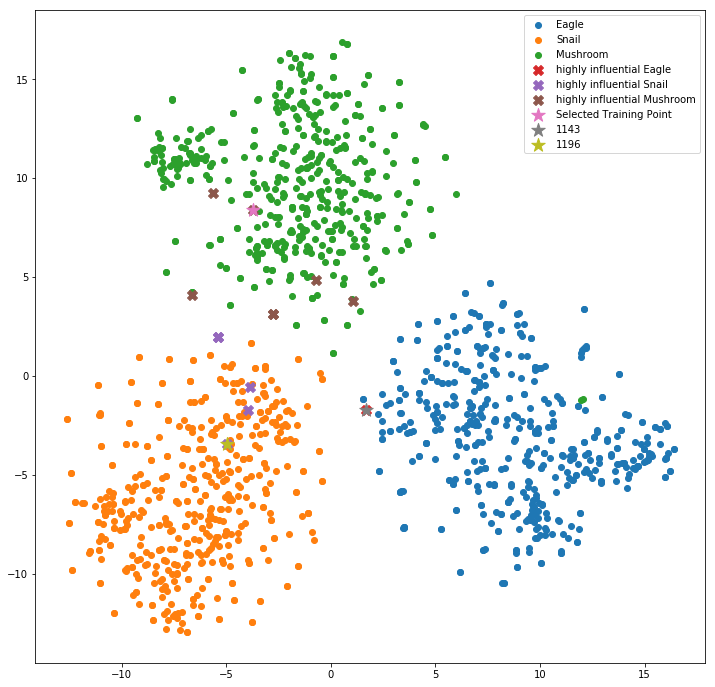

In [217]:
plt.figure(figsize=(12,12))

labels = ["Eagle",  "Snail", "Mushroom", "highly influential Eagle", "highly influential Snail", "highly influential Mushroom"]

# poisoned_incep = tsne_results[-1]
# tsne_results = tsne_results[:1500]

indices_dog = np.where(inception_X_train.labels == 0)
indices_fish = np.where(inception_X_train.labels == 1)
indices_mush = np.where(inception_X_train.labels == 2)
indices_all = [indices_dog, indices_fish, indices_mush]
normalized_pred_diff = pred_diff/np.linalg.norm(pred_diff)
indices_high = np.where(normalized_pred_diff > .1)

for class_label in range(num_classes):
    indices = indices_all[class_label]
    plt.scatter( tsne_results.T[0][indices], tsne_results.T[1][indices], label=labels[class_label]) 
for class_label in range(num_classes):
    indices = indices_all[class_label]
    high_ = np.where(np.in1d(indices_high, indices) == True)
    high = indices_high[0][high_]
    plt.scatter( tsne_results.T[0][high], tsne_results.T[1][high], label=labels[3 + class_label], marker='X', s=100)
#  698, 1323,  462,  647,  232, 1143,  657,  723,  665, 1196
# 723 1143
plt.scatter( tsne_results.T[0][723], tsne_results.T[1][723], label="Selected Training Point", marker='*', s=200)
# plt.scatter( poisoned_incep[[0]], poisoned_incep[[1]], label="Posioned Training Point", marker='*', s=200)
plt.scatter( tsne_results.T[0][665], tsne_results.T[1][665], label="1143", marker='*', s=200)
plt.scatter( tsne_results.T[0][1196], tsne_results.T[1][1196], label="1196", marker='*', s=200)

plt.legend()

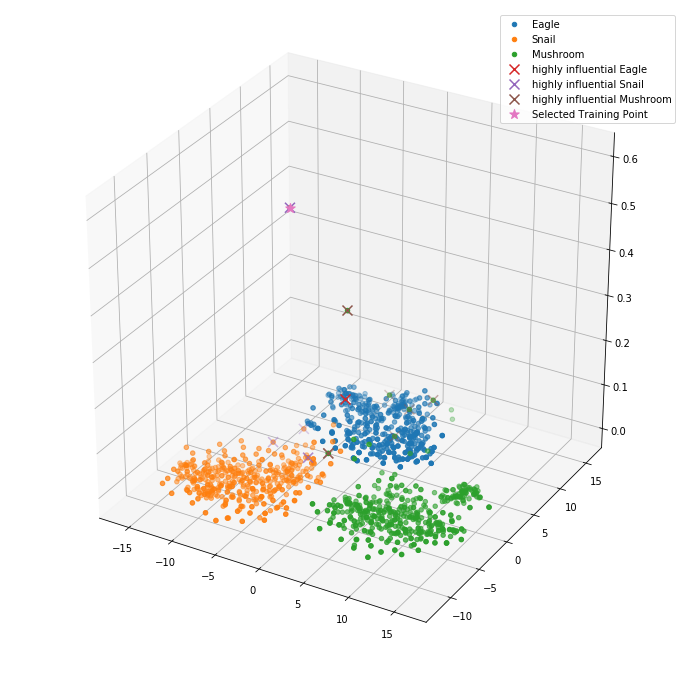

In [203]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
for class_label in range(num_classes):
    indices = indices_all[class_label]
    ax.scatter3D( tsne_results.T[0][indices], tsne_results.T[1][indices], normalized_pred_diff[indices], label=labels[class_label]) 
for class_label in range(num_classes):
    indices = indices_all[class_label]
    high_ = np.where(np.in1d(indices_high, indices) == True)
    high = indices_high[0][high_]
    ax.scatter3D( tsne_results.T[0][high], tsne_results.T[1][high], normalized_pred_diff[high], label=labels[3 + class_label], marker='x', s=100)
ax.scatter3D( tsne_results.T[0][698], tsne_results.T[1][698], normalized_pred_diff[698], label="Selected Training Point", marker='*', s=100)
plt.legend()

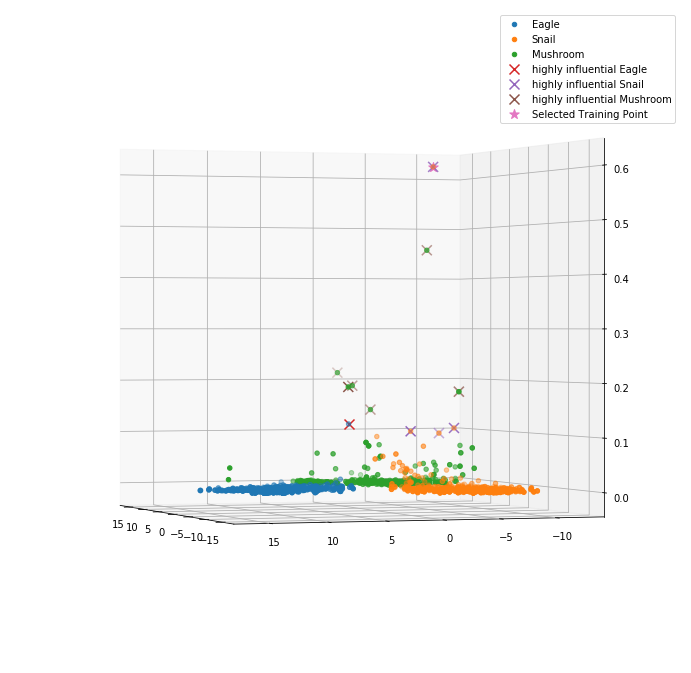

In [205]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(0, 160)
for class_label in range(num_classes):
    indices = indices_all[class_label]
    ax.scatter3D( tsne_results.T[0][indices], tsne_results.T[1][indices], normalized_pred_diff[indices], label=labels[class_label]) 
for class_label in range(num_classes):
    indices = indices_all[class_label]
    high_ = np.where(np.in1d(indices_high, indices) == True)
    high = indices_high[0][high_]
    ax.scatter3D( tsne_results.T[0][high], tsne_results.T[1][high], normalized_pred_diff[high], label=labels[3 + class_label], marker='x', s=100)
ax.scatter3D( tsne_results.T[0][698], tsne_results.T[1][698], normalized_pred_diff[698], label="Selected Training Point", marker='*', s=100)
plt.legend()

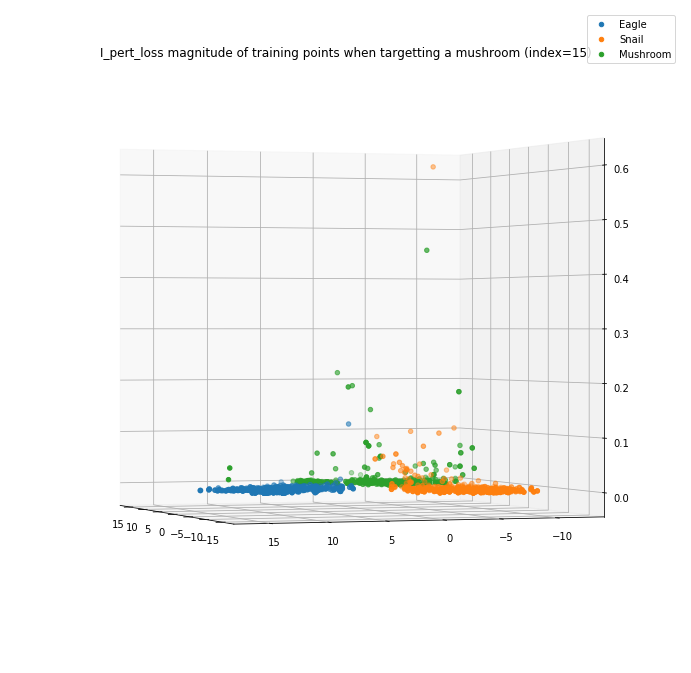

In [204]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(tsne_results.T[0], tsne_results.T[1], pred_diff)
plt.title("I_pert_loss magnitude of training points when targetting a mushroom (index={})".format(15))
normalized_pred_diff = pred_diff/np.linalg.norm(pred_diff)
for class_label in range(num_classes):
    indices = inception_X_train.labels == class_label
    label = ["Eagle", "Snail", "Mushroom"]
    ax.view_init(0, 160)
    ax.scatter3D(tsne_results.T[0][indices], tsne_results.T[1][indices], normalized_pred_diff[indices], label=label[class_label])
plt.legend()

In [51]:
z = np.zeros((tsne_results.shape[0], tsne_results.shape[0]))
z[]

(1500, 1500)

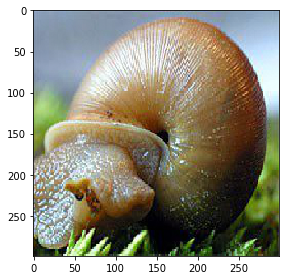

In [199]:
img = attack_success_image.reshape((img_side,img_side,num_channels)).copy()
render_img(img)

In [202]:
import Image

#Rescale to 0-255 and convert to uint8
rescaled = (1.0 / img.max() * (img - img.min())).astype(np.uint8)

im = Image.fromarray(rescaled)
im.save('test.jpeg')

TypeError: Cannot handle this data type

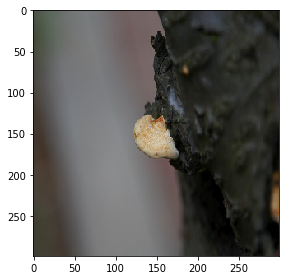

In [213]:
# 1323
# 232
# 698, 1323,  462,  647,  232, 1143,  657,  723,  665, 1196
img = data_sets.train.x[723].reshape((img_side,img_side,num_channels)).copy()
render_img(img)

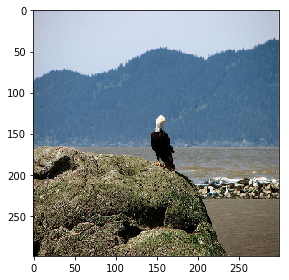

In [218]:
img = data_sets.train.x[1193].reshape((img_side,img_side,num_channels)).copy()
render_img(img)

In [9]:
data_sets.train.labels[723]

NameError: name 'data_sets' is not defined

In [56]:
img.size

(299, 299)

In [65]:
print(grad_influence_wrt_input_val_subset.shape)
pred_diff = np.sum(np.abs(grad_influence_wrt_input_val_subset), axis = 1)
indices_to_poison = np.argsort(pred_diff)[-1:-max_num_to_poison-1:-1]
print(indices_to_poison)

(1500, 268203)
[ 698 1323  647  462  665  723  232  706  420 1143]


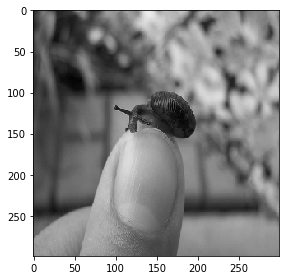

In [36]:
# for 15: 999,  172, 1302,  492, 1446,  164,  153, 1186,   47,  575
# 15, 6, 23
x = data_sets.train.x[999]
# x = data_sets.train.x[1446]
# 999,  709, 1446
render_img(x.reshape((img_side,img_side,num_channels)))

In [12]:
max(data_sets.train.labels)

2.0

In [4]:
data_sets.train.x.shape

(1500, 268203)

In [7]:
np.load(orig_weight_path)

array(None, dtype=object)

In [15]:
print(num_classes)

2


In [30]:
dup = DataSet(np.copy(data_sets.test.x), np.copy(data_sets.test.labels))
dup.labels[2] = 5

In [38]:
pred_diff = np.sum(np.abs(grad_influence_wrt_input_val_subset), axis = 1)
all_indices_to_poison = np.argsort(pred_diff)[-1:-max_num_to_poison-1:-1]
all_indices_to_poison

array([ 706,  420,  723,  236, 1323,   32, 1403,  417, 1312,  651])